# **PROYECTO INTEGRADOR DE DOMINIO AUTÓNOMO (PIDA)**
---


*The Learning Gate*
*   NOMBRE DEL PARTICIPANTE: Evelyn Aylin Rendon Medina
*   PROYECTO: Ventas Panattella
*   TRAYECTORIA: Citizen Data Scientist
*   TIPO APRENDIZAJE / DOMINIO APLICACIÓN: Educación continua


---
`PROPÓSITO DE LA CERTIFICACIÓN:` Evaluar, mediante un proyecto que el conjunto de competencias adquiridas en el programa de entrenamiento genere en la organización y/o persona, un impacto de mejora medible, claramente estructurado y autogestionado por parte del participante.

## **ETAPA I:** Entendimiento del negocio
Esta etapa consiste en definir el alcance del proyecto, considerando los objetivos comerciales, para evaluar con mayor precisión el impacto del proyecto en la empresa/organización.


* **Antecedentes:** ¿En qué empresa/organización se desarrolla el proyecto? ¿Cuál o cuáles son los proceso o procesos de negocios que serán impactados por el mismo?

* **Formulación del problema:** ¿Qué es lo que se intenta resolver?

* **Valor agregado:** ¿Por qué es importante resolver este problema?

* **Objetivos:** ¿Cuál es la meta prevista? ¿Cuál(es) es(son) los criterios de éxito?


* **Diccionario de datos:** ¿Qué representa cada variable?


* **Predictores y respuesta:** ¿Cuáles son las entradas y la(s) salida(s)?

---

## **ETAPA II:** Entendimiento de los datos

Esta etapa consiste en la ingestión o recopilación de los datos y su exploración, mediante estadísticas descriptiva e inferencial y visualizaciones concluyentes.


In [9]:
# Inclusión de las bibliotecas necesarias
import pandas as pd
import pyodbc
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [10]:
# Identificación de los drivers para conexión a SQL Server
pyodbc.drivers()

['SQL Server',
 'SQL Server Native Client 11.0',
 'ODBC Driver 11 for SQL Server',
 'ODBC Driver 13 for SQL Server',
 'CAMWorks SQLite3 ODBC Driver',
 'MySQL ODBC 8.1 ANSI Driver',
 'MySQL ODBC 8.1 Unicode Driver',
 'Oracle en OraDB21Home1',
 'Oracle in XE',
 'ODBC Driver 17 for SQL Server',
 'ODBC Driver 18 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)']

In [11]:
# Conexión | Lectura
server = 'localhost'
database = 'master'
driver = '{ODBC Driver 17 for SQL Server}'
#print(pyodbc.drivers())

# Conexión | Windows Authentication
connection_string = f"""
DRIVER={driver};
SERVER={server};
DATABASE={database};
Trusted_Connection=yes;
TrustServerCertificate=yes;
"""

# Conexión | Consulta
conn = pyodbc.connect(connection_string)
query = '''
SELECT VENTA, CURRENT_ARTIC ARTICULO, DESCRIP, CNT_PRODS_VENTA, TIPO_DOC, DIAS,
CASE WHEN UNIDAD LIKE 'BULTO%' THEN 'BULTO(S)' 
    WHEN UNIDAD LIKE 'CAJA%' THEN 'CAJA(S)'  ELSE UNIDAD END UNIDAD,
CASE WHEN LAST_ARTIC<>CURRENT_ARTIC THEN ROUND((LAST_CANTIDAD*44)/25,0) ELSE ROUND(LAST_CANTIDAD,0) END CANTIDAD,
CASE WHEN LAST_ARTIC<>CURRENT_ARTIC THEN 
	ROUND(((LAST_CANTIDAD*LAST_PRECIO)/(LAST_CANTIDAD*44))*25,4) ELSE LAST_PRECIO END PRECIO,
F_EMISION
FROM (SELECT VENTA, ARTICULO LAST_ARTIC, DESCRIP, UNIDAD, CANTIDAD LAST_CANTIDAD, PRECIO LAST_PRECIO, F_EMISION,
CNT_PRODS_VENTA, TIPO_DOC, DIAS,
CASE UPPER(ARTICULO)
    WHEN 'HA-08' THEN 'HA-008'
    WHEN 'HA-02' THEN 'HA-002'
    WHEN 'HA-04' THEN 'HA-004'
    WHEN 'HA-03' THEN 'HA-003'
    WHEN 'HA-11' THEN 'HA-011'
    WHEN 'HA-05' THEN 'HA-005'
    WHEN 'HA-06' THEN 'HA-006'
    WHEN 'HA-07' THEN 'HA-007'
    WHEN 'HA-10' THEN 'HA-010'
    WHEN 'HA-09' THEN 'HA-009'
    ELSE UPPER(ARTICULO)
END AS CURRENT_ARTIC
FROM master.dbo.Ventas
WHERE UPPER(ARTICULO) IN ('GV-01','AC-02','HA-008','HA-02','HA-002','HA-004','HA-03','HA-003','HA-11'
,'HA-011','HA-005','HA-006','HA-007','HA-010','HA-009','ES-07','ES-02','ES-03','ES-04','ES-05'
,'GV-COL','ES-08','AC-03','SP-01','SP-11','SP-09','ES-09','AC-MAR','FARDO-TRIGO')) A
'''
original_df = pd.read_sql(query, conn)

conn.close()


C:\Users\PROPIETARIO\AppData\Local\Temp\ipykernel_23812\1433941450.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  original_df = pd.read_sql(query, conn)


Conexión a SQL server consultando solamente los datos relevantes, dispuestos en el diccionario presentado
Cabe destacar que se realiza un preprocesamiento de los artículos definidos cuyo tamaño de empaque cambió de 44kg a 25kg, donde se ajusta la cantidad equivalente y unifican las etiquetas a las actuales.

In [12]:
# Muestra

original_df.head()

,VENTA,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION
0,206506.0,HA-007,HARINA SELECTA AP 25 KGS,3.0,REM,30.0,BULTO(S),35.0,390.0,20251028.0
1,206506.0,HA-005,HARINA ESPIGA 25 KGS,3.0,REM,30.0,BULTO(S),15.0,400.0,20251028.0
2,206506.0,GV-COL,GRASA COLON 24 KGS,3.0,REM,30.0,CAJA(S),4.0,830.0,20251028.0
3,206507.0,HA-003,HARINA TRECE 25 KGS,1.0,REM,30.0,BULTO(S),100.0,390.0,20251028.0
4,206508.0,HA-007,HARINA SELECTA AP 25 KGS,2.0,REM,30.0,BULTO(S),100.0,380.0,20251028.0


Las siguientes son algunas de las preguntas comunes que se pueden abordar a través de un análisis exploratorio de datos:
* ¿Cuál es la dimensionalidad del conjunto de datos?
* ¿Qué tipo de datos tienen las variables?
* ¿Hay valores faltantes en el conjunto de datos?
* ¿Cuáles son las estadísticas resumidas del conjunto de datos?
* ¿Cuál es la cardinalidad de las variables categóricas?

In [13]:
# ¿Cuál es la dimensionalidad del conjunto de datos?

#original_df.shape
print('Columnas: ', original_df.shape[1], '\nRegistros: ', original_df.shape[0])


Columnas:  10 
Registros:  88733


Se mantienen solamente 9 columnas relevantes. En registros, limitando el set de datos a solo productos activos, se disponen 88,733

In [14]:
# ¿Qué tipo de datos tienen las variables?

original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88733 entries, 0 to 88732
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VENTA            88733 non-null  float64
 1   ARTICULO         88733 non-null  object 
 2   DESCRIP          88733 non-null  object 
 3   CNT_PRODS_VENTA  88733 non-null  float64
 4   TIPO_DOC         88733 non-null  object 
 5   DIAS             88733 non-null  float64
 6   UNIDAD           88733 non-null  object 
 7   CANTIDAD         88733 non-null  float64
 8   PRECIO           88733 non-null  float64
 9   F_EMISION        88733 non-null  float64
dtypes: float64(6), object(4)
memory usage: 6.8+ MB


Se observa que se interpretan de forma incorrecta algunos de los tipos de datos en las variables. Por ejemplo, la venta es un identificador y se identifica como tipo de dat flotante
Por tanto, en el siguiente paso se realizará el ajuste al tipo esperado de datos

In [15]:
# Ajuste el tipo de datos esperado

df = original_df.copy()

dtype_mapping = {
    'VENTA': 'Int64',
    'ARTICULO': 'string',
    'DESCRIP': 'string',
    'UNIDAD': 'string',
    'CNT_PRODS_VENTA': 'Int64',
    'TIPO_DOC': 'string',
    'CANTIDAD': 'Int64',
    'PRECIO': 'float64',
    'DIAS': 'Int64'
    #'F_EMISION': 'string', # Procesado abajo
}

df = df.astype(dtype_mapping)
df = df.drop('VENTA', axis=1)
# Con base en la retroalimentación, se elimina la variable de venta

# Formato de fecha
date_cols = ['F_EMISION']
for col in date_cols:
    df[col] = pd.to_datetime(df[col].dropna().astype(int).astype(str), format='%Y%m%d', errors='coerce')

df.dtypes

ARTICULO           string[python]
DESCRIP            string[python]
CNT_PRODS_VENTA             Int64
TIPO_DOC           string[python]
DIAS                        Int64
UNIDAD             string[python]
CANTIDAD                    Int64
PRECIO                    float64
F_EMISION          datetime64[ns]
dtype: object

Comprobamos que el conteo de productos por venta, cantidad vendida y días ahora se manejan como enteros. Por otro lado, artículo, descripción y tipo de documento son cadenas de texto
Finalmente, el precio es un valor flotante y la fecha se reconoce como fecha

In [16]:
# Revisión del ajuste

df.head()

,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28


In [17]:
# ¿Hay valores faltantes en el conjunto de datos?

df.isnull().sum()

ARTICULO           0
DESCRIP            0
CNT_PRODS_VENTA    0
TIPO_DOC           0
DIAS               0
UNIDAD             0
CANTIDAD           0
PRECIO             0
F_EMISION          0
dtype: int64

Para el set de datos limitado a las variables de interés y solo productos activos, no se cuenta con ningún valor faltante

In [18]:
# ¿Cuáles son las estadísticas resumidas del conjunto de datos?

df.describe()

,CNT_PRODS_VENTA,DIAS,CANTIDAD,PRECIO,F_EMISION
count,88733.0,88733.0,88733.0,88733.000000,88733
mean,3.273179,22.036762,138.016172,315.884850,2018-11-26 10:19:29.341732864
min,1.0,0.0,1.0,0.000000,2002-07-30 00:00:00
25%,1.0,0.0,20.0,196.022700,2014-10-09 00:00:00
50%,1.0,30.0,88.0,243.506500,2020-04-05 00:00:00
75%,3.0,30.0,176.0,410.000000,2023-01-16 00:00:00
max,51.0,120.0,35552.0,10000.000000,2025-10-28 00:00:00
std,5.529419,18.578752,271.792082,181.172585,NaN


Es posible observar que en promedio, cada venta contiene alrededor de tres productos, un lógico mínimo de uno y un máximo de 51. El valor máximo podría ser un valor atípico o incluso un error, lo cual se verficará posteriomente
Por otro lado, por transacción se vende un promedio de 138 unidades. Esto puede no ser propiamente representativo, ya que se mezclan unidades de medida, que suelen tener diferentes volúmenes de venta, lo que podría sesgar nuestra interpretación. Sucede algo similar con el precio, aunque 315 podría sonar medianamente congruente con los precios de los bultos, sabemos que debe estar sesgado por los demás productos de precios inferiores
Por otro lado, los registros comienzan desde 2002 y se tiene una fotografía hasta el 28 de octubre del 2025

In [19]:
# ¿Cuál es la cardinalidad de las variables categóricas?

print('Productos únicos: ', len(df['ARTICULO'].unique()), '\n', df['ARTICULO'].unique().tolist())
print('Unidades de medida: ', len(df['UNIDAD'].unique()), '\n', df['UNIDAD'].unique().tolist())

Productos únicos:  26 
 ['HA-007', 'HA-005', 'GV-COL', 'HA-003', 'SP-09', 'HA-002', 'HA-004', 'HA-011', 'HA-006', 'SP-01', 'AC-MAR', 'ES-03', 'ES-08', 'HA-009', 'GV-01', 'HA-010', 'ES-09', 'FARDO-TRIGO', 'AC-03', 'ES-02', 'AC-02', 'ES-07', 'HA-008', 'ES-04', 'ES-05', 'SP-11']
Unidades de medida:  4 
 ['BULTO(S)', 'CAJA(S)', 'BIDON', 'UNIDAD']


Las categorías en este caso, podrían manejarse a nivel producto, que sería el más granular. En este caso, se tienen 26 diferentes. Alternativamente, podríamos la unidad de medida sería una categoría con menor nivel de detalle, de las cuales existen 7

In [20]:
# Ventas por producto

cntVentas= df.groupby(['ARTICULO','DESCRIP'])['CANTIDAD'].sum().sort_values(ascending=False).reset_index()
cntVentas

,ARTICULO,DESCRIP,CANTIDAD
0,HA-002,HARINA DE TRIGO ESMERALDA 44 KG.,5302967
1,HA-003,HARINA DE TRIGO TRECE 44 KG.,4316355
2,HA-011,"HARINA DE TRIGO "" VIRGINIA PANIFICABLE"" 44 KGS.",514014
3,FARDO-TRIGO,"FARDO DE HARINA ""LAZIALI"" 10 KGS",504567
4,HA-002,HARINA ESMERALDA 25 KGS,467156
5,HA-003,HARINA TRECE 25 KGS,314635
6,GV-01,GRASA JEFA 24 KGS,269453
7,HA-007,HARINA SELECTA AP 25 KGS,147441
8,HA-005,HARINA ESPIGA 25 KGS,105762
9,HA-004,HARINA ESMERALDA AP 25 KGS,93154


Se obtiene solamente de manera informativa las ventas en cantidad realizadas por producto. El resultado obtenido es congruente con el comportamiento observado

Genera algunos gráficos para familiarizarte con el conjunto de datos. Al menos deberás incluir los que te permitan responder:

* ¿Hay valores atípicos?
* ¿Existen distribuciones sesgadas en el conjunto de datos?
* ¿Cómo se distribuyen los datos en función de diferentes categorías?
* ¿Hay correlación entre las variables dependientes e independientes?
* ¿Hay desequilibrio en las clases de la variable objetivo?

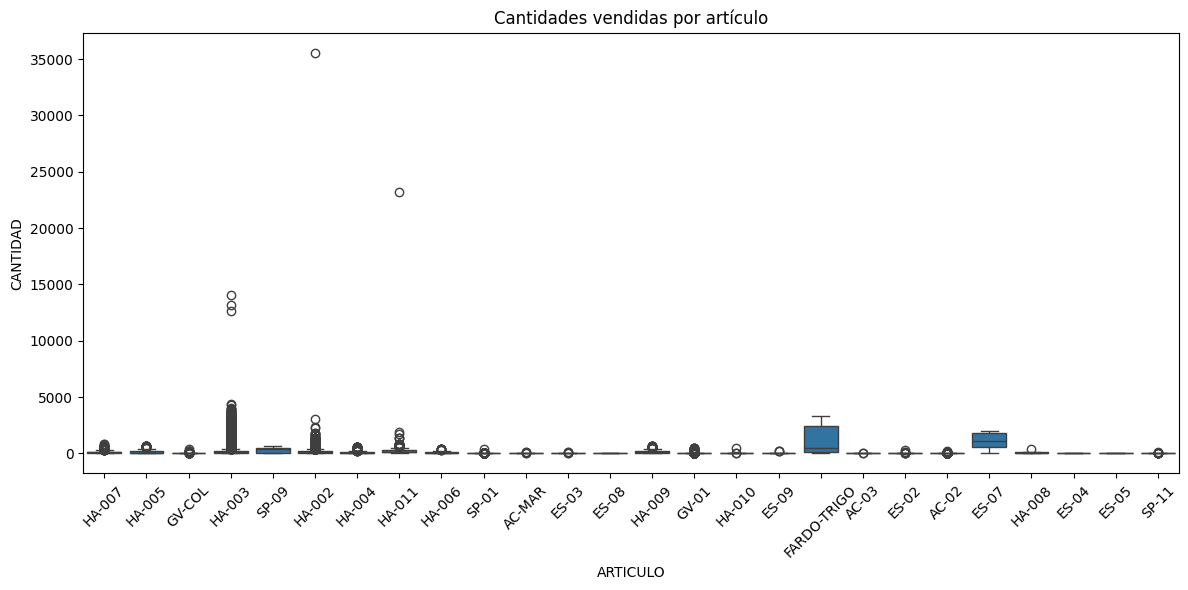

In [21]:
# ¿Hay valores atípicos?

plt.figure(figsize=(12, 6))
sns.boxplot(x='ARTICULO', y='CANTIDAD', data=df)
plt.title('Cantidades vendidas por artículo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Se observan valores atípicos en la mayoría de los productos, sobre todo los más vendidos. Los más notorio son en el producto HA-002 y HA-011, que incluso disminuyen la amplitud de las demás cajas

In [22]:
df.select_dtypes(include='number').corr()

,CNT_PRODS_VENTA,DIAS,CANTIDAD,PRECIO
CNT_PRODS_VENTA,1.000000,-0.106338,-0.108392,0.133920
DIAS,-0.106338,1.000000,0.131411,-0.027935
CANTIDAD,-0.108392,0.131411,1.000000,-0.189473
PRECIO,0.133920,-0.027935,-0.189473,1.000000


### AUTOEDA

In [23]:
# ¿Existen distribuciones sesgadas en el conjunto de datos?
# ¿Cómo se distribuyen los datos en función de diferentes categorías?
# ¿Hay correlación entre las variables dependientes e independientes?
# ¿Hay desequilibrio en las clases de la variable objetivo?

pandas_report = ProfileReport(df)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 16.98it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Los resultados obtenidos en el YData Profiling Report nos permiten ver valores numéricos complementarios a los obtenidos anteriormente, como también comprueba lo expresado por instrucciones específicas.

Por ejemplo, observamos la agrupación de las variables por tipos, ligeramente más desagregado que el detalle obtenido, pues divide en numéricas sin especificar el tipo particular. Por otro lado, podemos ver de forma sencilla en una misma tabla las estadísticas del set de datos, donde se confirma que no hay datos faltantes, que la dimensión de los datos coincide e incluso determina la cantidad de memoria empleada.

Cabe destacar que la variable días contiene una considerable cantidad de valores en cero, y hay también algunos presentes en el precio. Si bien esto puede ser considerado como un error, corresponden a bultos sin cargo que pueden darse como bonificación y ocasiones donde el acuerdo comercial dicta que la transacción se realizará sin crédito, pagando por tanto de contado.

Se ahondará en la interpretación de los resultados en el siguiente apartado.

In [24]:
# Hide unused axes
def hide_axes(i, axes, fig):
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

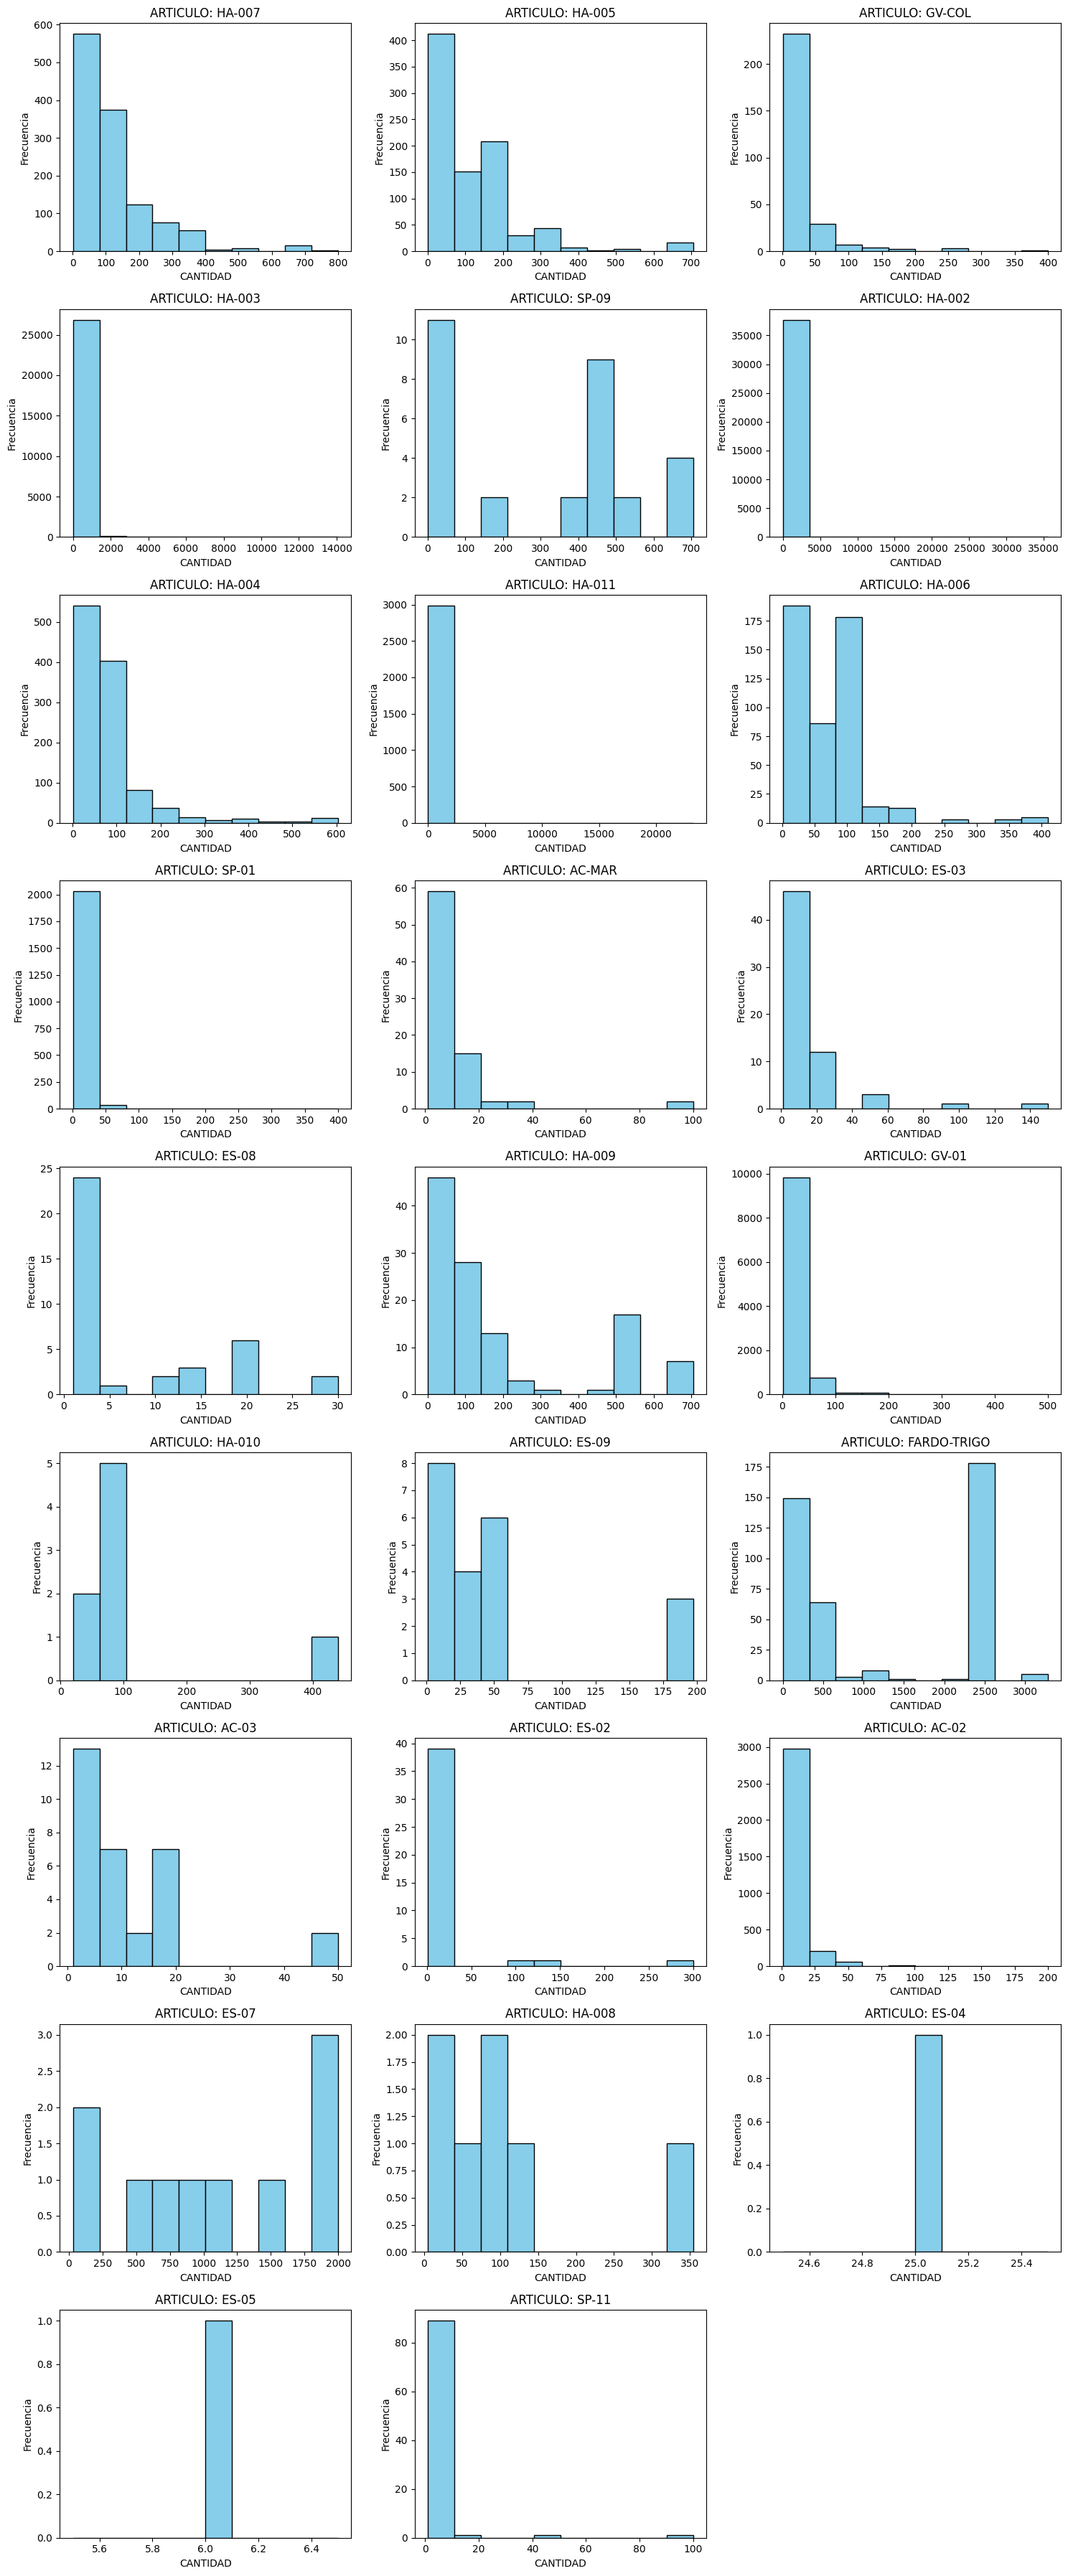

In [25]:
# ¿Existen distribuciones sesgadas en el conjunto de datos?
# ¿Cómo se distribuyen los datos en función de diferentes categorías?

articulos = df['ARTICULO'].unique()
n = len(articulos)

# Layout
cols = 3
rows = -(-n // cols)  # Ceiling division

# Subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Histogram
for i, articulo in enumerate(articulos):
    subset = df[df['ARTICULO'] == articulo]
    axes[i].hist(subset['CANTIDAD'], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(f'ARTICULO: {articulo}')
    axes[i].set_xlabel('CANTIDAD')
    axes[i].set_ylabel('Frecuencia')

hide_axes(i, axes, fig)
plt.tight_layout()
plt.show()

De forma complementaria, se obtiene un histograma por producto, donde no se visualizan comportamientos típicamente normales por categoría de producto

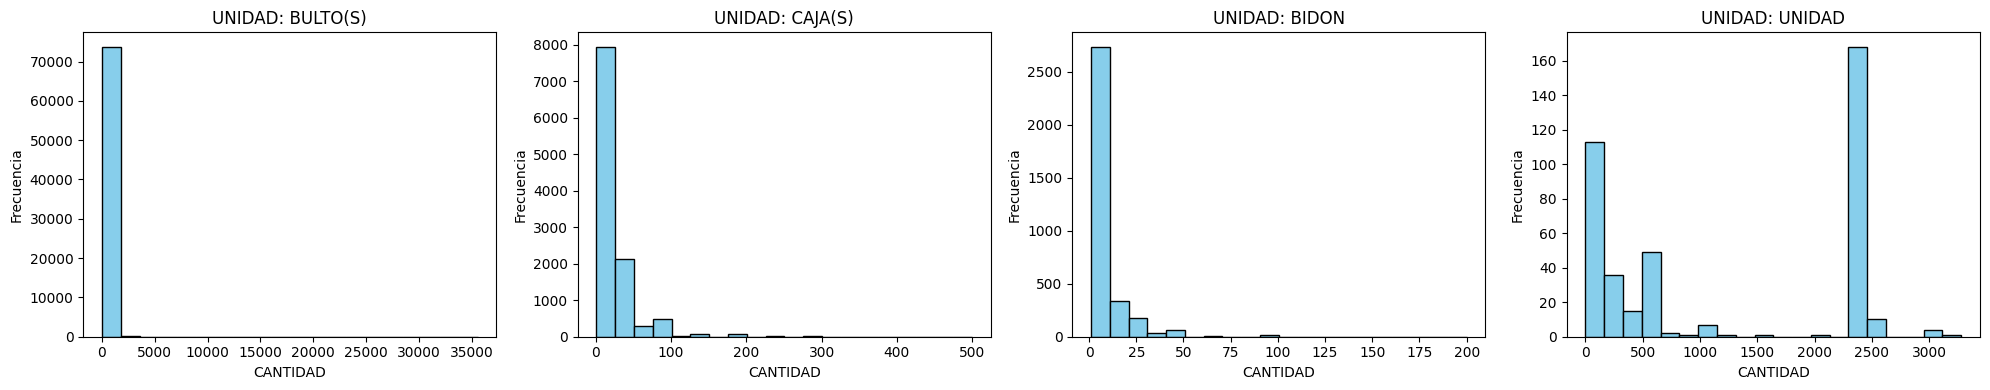

In [26]:
# ¿Existen distribuciones sesgadas en el conjunto de datos?
# ¿Cómo se distribuyen los datos en función de diferentes categorías?

unidades = df['UNIDAD'].unique()
n2 = len(unidades)

# Layout
cols = 4
rows = -(-n2 // cols)  # Ceiling division

# Subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Histogram
for i, unidad in enumerate(unidades):
    subset = df[df['UNIDAD'] == unidad]
    axes[i].hist(subset['CANTIDAD'], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'UNIDAD: {unidad}')
    axes[i].set_xlabel('CANTIDAD')
    axes[i].set_ylabel('Frecuencia')

hide_axes(i, axes, fig)
plt.tight_layout()
plt.show()

In [27]:
df.head()

,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28


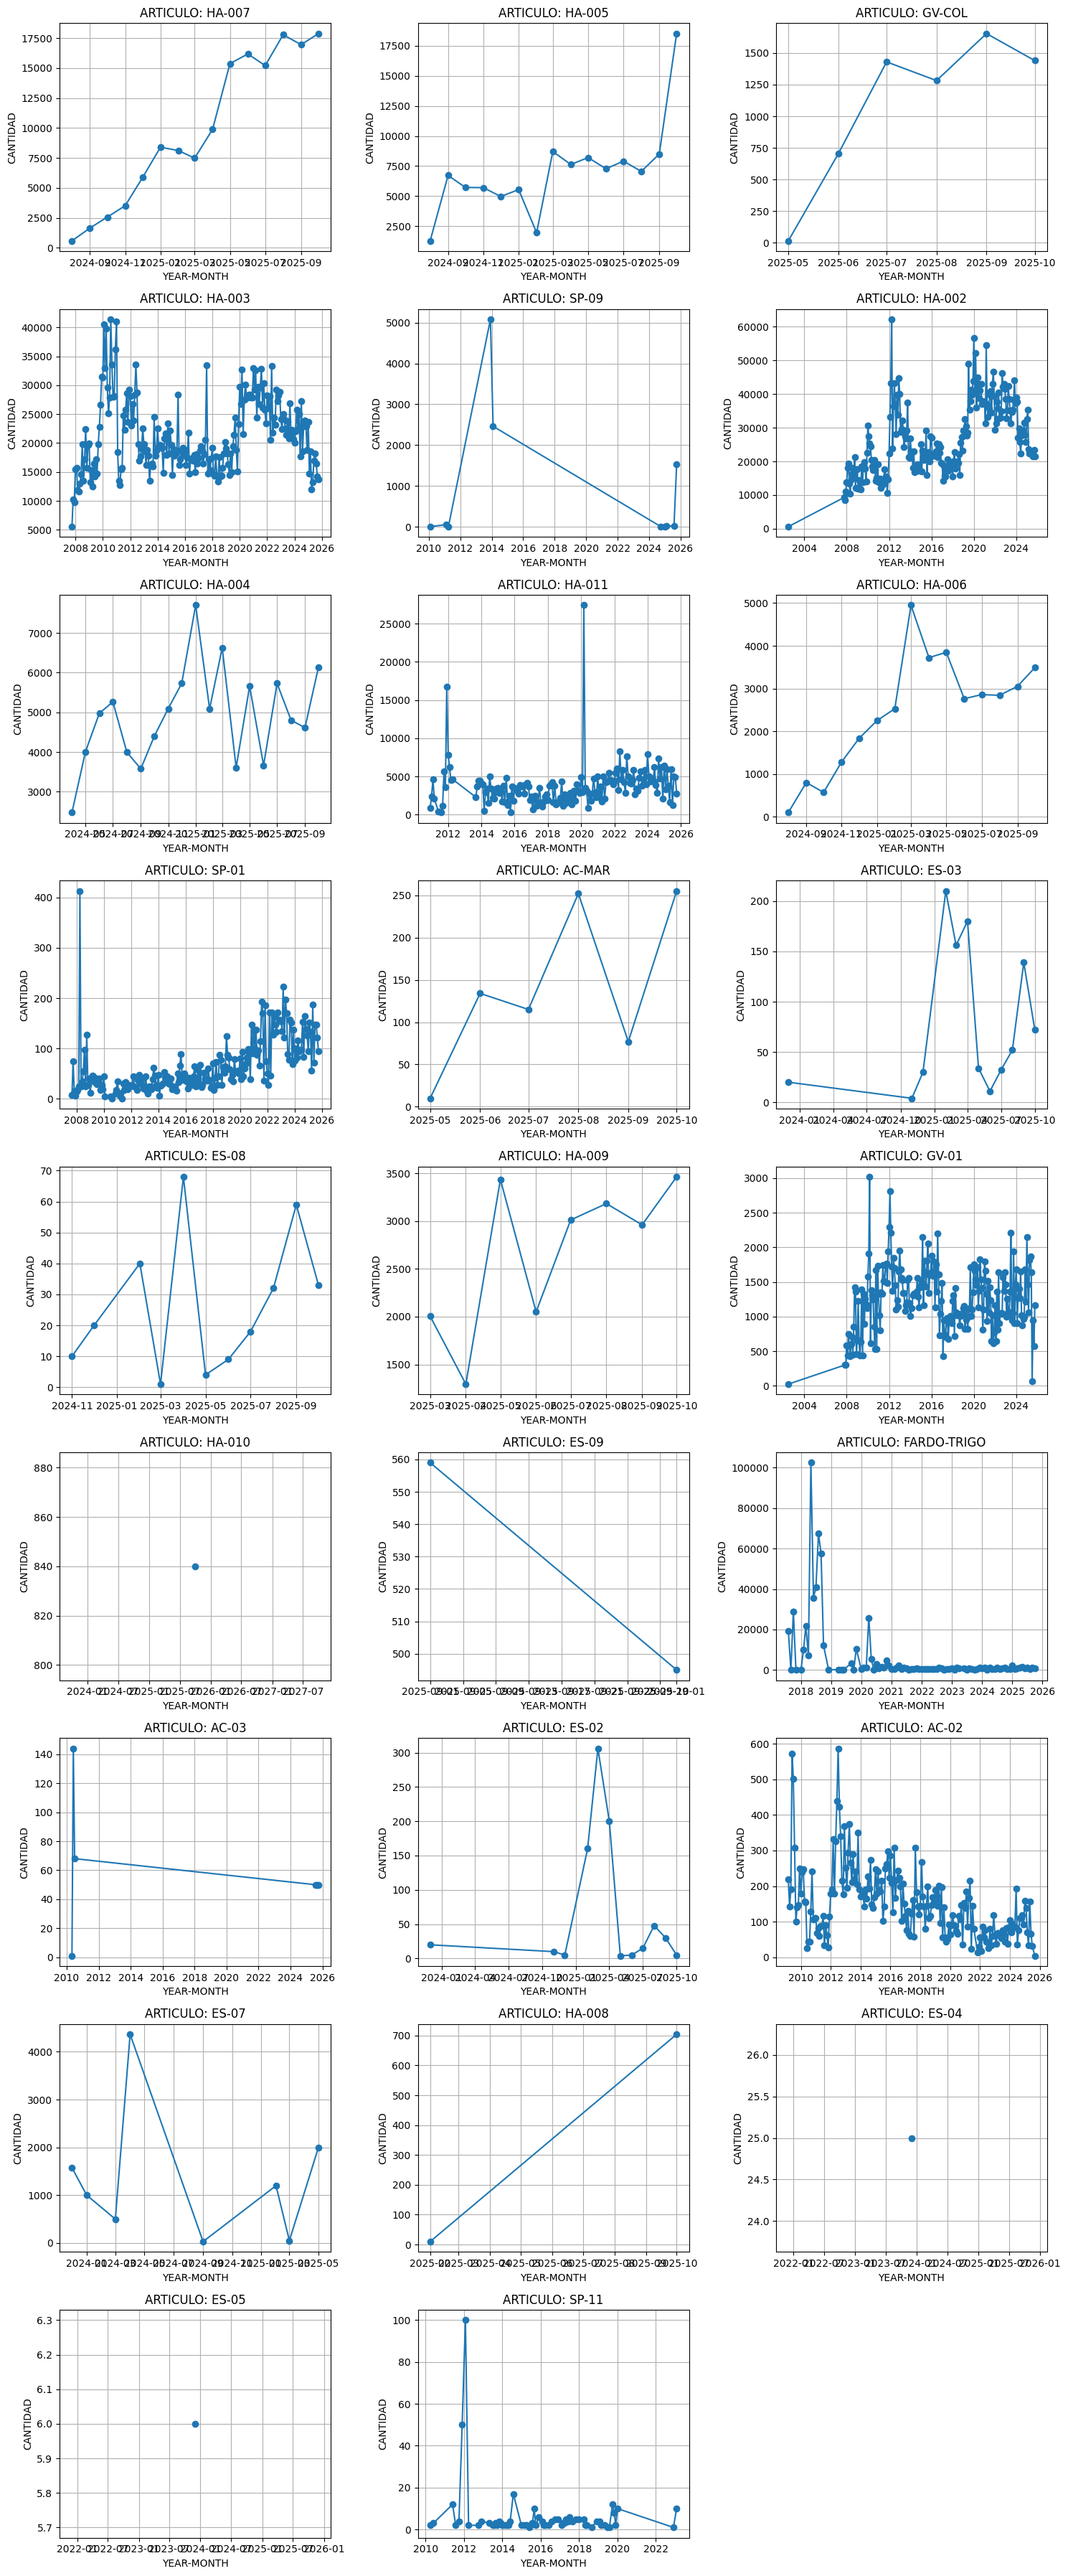

In [28]:
# Series de tiempo

# YEAR-MONTH
df['YEAR_MONTH'] = df['F_EMISION'].dt.to_period('M').dt.to_timestamp()
#articulos = df['ARTICULO'].unique()
n3 = len(articulos)

# Layout
cols = 3
rows = -(-n3 // cols)  # Ceiling division

# Subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Plot for each ARTICULO
for i, articulo in enumerate(articulos):
    subset = (
        df[df['ARTICULO'] == articulo]
        .groupby('YEAR_MONTH')['CANTIDAD']
        .sum()
        .reset_index())

    axes[i].plot(subset['YEAR_MONTH'], subset['CANTIDAD'], marker='o')
    axes[i].set_title(f'ARTICULO: {articulo}')
    axes[i].set_xlabel('YEAR-MONTH')
    axes[i].set_ylabel('CANTIDAD')
    axes[i].grid(True)


hide_axes(i, axes, fig)
plt.tight_layout()
plt.show()


Por unidad de medida se observa en la mayoría de los casos sesgo hacia la derecha, mientras que la frecuencia se anida en el primer bin. Lo anterior no es aplicable para la unidad en sí o piezas, que tiene un comportamiento relativamente bimodal

**CONCLUSIONES:** ¿Cuáles son los hallazgos más importantes del análisis exploratorio de datos?

Tras llevar a cabo el análisis exploratorio se puede detectar que el conjunto de datos es considerablemente pequeño, sobre todo en columnas o variables que ayuden al modelo a detectar patrones que le permitan predecir las ventas por mes. Por tanto, en la siguiente fase de preparación de los datos será indispensable crear características de valor que ayuden a capturar el comportamiento.

Por otro lado, se observan valores atípicos en la mayoría de los productos y, sobre todo en los más vendidos. Un ejemplo muy sobrealiento aparece en el producto HA-002, que indica una venta alrededor de los 35,000 bultos, lo cual parece inverosímil y habrá que procesarse para evitar un ajuste incorrecto en el modelo.
Además, el análisis también permitió definir que el producto más vendido es el HA-002, seguido del HA-003 y en tercer lugar el GV-01. Cuarto y quinto tienen valores parecidos, e incluso el acumulado de otros productos es mayor que el de ambos. Es decir, los dos primeros lugares en ventas los ocupa la harina, mientras que el tercero es grasa.

Adicionalmente, sabemos ahora que el promedio de productos por venta es de tres distintos. Es decir, que de lo anterior se podría especular que el comportamiento de la mayoría de los clientes, el cual consiste en solicitar dos harinas diferentes (probablemente el top) y acompañar el pedido con grasa.

Respecto al conteo de artículos, se observa el top de productos con mayor frecuencia, lo cual tiene sentido con el comportamiento. La descripción al ir de la mano del producto presenta un comportamiento paralelo. Lo anterior también se visualiza a través de la variable de unidad, donde son los bultos de harina los registros más frecuentes

Si se observa la cantidad de productos por venta, se aprecia sesgada hacia la derecha. Similar ocurre con precio, aunque en los primeros bines tenía una tendencia normal. Finalmente, la fecha de emisión se encuentra sesgada hacia la izquierda, aunque la frecuencia es mayor en las fechas más recientes.

Además, observamos sin duda que las clases están desbalanceadas, tanto si lo vemos por marca o productos distintos, como también por sus unidades de medida. Las harinas, cuya unidad es bulto poseen ventas muy superiores a las cajas, bidones y unidades o piezas. Por tanto, es vital contemplar o por ello se designa hacer la predicción por producto.

Finalmente, no parece haber una correlación realmente distintiva entre las variables, más allá de lo lógico, como lo es descripción con unidad y artículo. Cabe destacar que, si bien se toma la variable descripción para tener más contexto durante el análisis, no es una variable que se considerará en el modelo, pues no aporta valor predictivo.


---

## **ETAPA III:** Preparación de los datos

En esta etapa se aplican operaciones comunes para convertir los datos crudos del mundo real, en un conjunto de variables útiles para el aprendizaje automático.

El procesamiento puede incluir:
* Manejo de valores faltantes y atípicos
* Generación de nuevas características
* Discretización o binning
* Codificación
* Escalamiento
* Transformación

### Manejo de valores atípicos

In [29]:
# Identificar valores atípicos

# IQR
Q1 = df['CANTIDAD'].quantile(0.25)
Q3 = df['CANTIDAD'].quantile(0.75)
IQR = Q3 - Q1

# Thresholds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df[(df['CANTIDAD'] < lower) | (df['CANTIDAD'] > upper)]
print('Outliers: ', len(df[(df['CANTIDAD'] < lower) | (df['CANTIDAD'] > upper)]))
outliers.head()

Outliers:  4755


,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH
6,HA-002,HARINA ESMERALDA 25 KGS,1,FAC,45,BULTO(S),439,380.0,2025-10-28,2025-10-01
17,HA-002,HARINA ESMERALDA 25 KGS,1,FAC,45,BULTO(S),528,426.0,2025-10-28,2025-10-01
23,HA-005,HARINA ESPIGA 25 KGS,1,REM,45,BULTO(S),704,400.0,2025-10-28,2025-10-01
24,SP-09,SALVADO 25 KG,1,REM,60,BULTO(S),704,115.0,2025-10-28,2025-10-01
51,HA-007,HARINA SELECTA AP 25 KGS,1,REM,45,BULTO(S),704,380.0,2025-10-27,2025-10-01


In [30]:
# Reemplazar valores atípicos

transformed_df = df.copy()
transformed_df['CANTIDAD'] = transformed_df['CANTIDAD'].clip(lower=lower, upper=upper)

print('Outliers: ', len(transformed_df[(transformed_df['CANTIDAD'] < lower) | (transformed_df['CANTIDAD'] > upper)]))
transformed_df.head()


Outliers:  0


,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10-01
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10-01
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10-01
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10-01
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10-01


Nota: Algunas transformaciones se realizan desde la consulta, como ajuste en las etiquetas y la conversión a bultos de 25kg. Lo anterior fue identificado por medio del análisis exploratorio e iterado para obtener estadísticos representativos

### Generación de nuevas características

In [31]:
# Agregaciones por año y mes

transformed_df['YEAR'] = transformed_df['F_EMISION'].dt.year
transformed_df['MONTH'] = transformed_df['F_EMISION'].dt.month
transformed_df['YEAR_MONTH'] = transformed_df['F_EMISION'].dt.to_period('M')

transformed_df.head()

,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10,2025,10
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10,2025,10
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10,2025,10
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10,2025,10
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10,2025,10


In [32]:
# Temporada del año en que se realiza la venta

def get_season(date):
    month = date.month
    
    if month in [3, 4, 5]:
        return '1'  #Primavera
    elif month in [6, 7, 8]:
        return '2'  #Verano
    elif month in [9, 10, 11]:
        return '3'  #Otoño
    else:
        return '4'  #Invierno


transformed_df['TEMPORADA'] = transformed_df['F_EMISION'].apply(get_season)

print('Temporadas: ', len(transformed_df['TEMPORADA'].unique()), '\n', transformed_df['TEMPORADA'].unique().tolist())
transformed_df.head()


Temporadas:  4 
 ['3', '1', '2', '4']


,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10,2025,10,3
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10,2025,10,3
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10,2025,10,3
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10,2025,10,3
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10,2025,10,3


In [33]:
# Verificar resultados

print('Temporadas: ',transformed_df.groupby('TEMPORADA')['MONTH'].unique(), '\n\n', 
      transformed_df['TEMPORADA'].value_counts(), '\n\n CANTIDAD',
      transformed_df.groupby('TEMPORADA')['CANTIDAD'].sum())


Temporadas:  TEMPORADA
1      [5, 4, 3]
2      [6, 8, 7]
3    [10, 9, 11]
4     [1, 2, 12]
Name: MONTH, dtype: object 

 TEMPORADA
3    22608
2    22520
1    21957
4    21648
Name: count, dtype: int64 

 CANTIDAD TEMPORADA
1    2559168
2    2579280
3    2658276
4    2614046
Name: CANTIDAD, dtype: Int64


In [34]:
# Festividades con pan característico

def holiday(date):
    month = date.month
    
    if month in [9, 11, 12]:
        return 1 #Yes
    else:
        return 0 #No


transformed_df['FESTIVIDAD'] = transformed_df['F_EMISION'].apply(holiday)

print('Festividades: ', len(transformed_df['FESTIVIDAD'].unique()), '\n', transformed_df['FESTIVIDAD'].unique().tolist())
transformed_df.head()


Festividades:  2 
 [0, 1]


,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA,FESTIVIDAD
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10,2025,10,3,0
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10,2025,10,3,0
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10,2025,10,3,0
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10,2025,10,3,0
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10,2025,10,3,0


In [35]:
# Señalar marcas propias (primera opción a promocionar)

marcas = ['HA-002', 'HA-004', 'HA-003', 'FARDO-TRIGO', 'HA-011']
transformed_df['MARCA_CASA'] = transformed_df['ARTICULO'].isin(marcas).astype(int)

transformed_df.head()

,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA,FESTIVIDAD,MARCA_CASA
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10,2025,10,3,0,0
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10,2025,10,3,0,0
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10,2025,10,3,0,0
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10,2025,10,3,0,1
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10,2025,10,3,0,0


In [36]:
# Verificar resultados

print('Festividades: ', len(transformed_df['MARCA_CASA'].unique()), '\n', transformed_df['MARCA_CASA'].unique().tolist())
print('\nMarcas propias: ', transformed_df['MARCA_CASA'].value_counts())

Festividades:  2 
 [0, 1]

Marcas propias:  MARCA_CASA
1    69205
0    19528
Name: count, dtype: int64


### Codificación

In [37]:
# Codificar ARTICULO
# Se realiza de forma manual para conservar la interpretación

# Diccionario para interpretar código de producto
article_mapping = {label: idx+1 for idx, label in enumerate(transformed_df['ARTICULO'].unique())}

# Codificar
transformed_df['ARTICULO_CODE'] = transformed_df['ARTICULO'].map(article_mapping)

print(article_mapping)
transformed_df.head()


{'HA-007': 1, 'HA-005': 2, 'GV-COL': 3, 'HA-003': 4, 'SP-09': 5, 'HA-002': 6, 'HA-004': 7, 'HA-011': 8, 'HA-006': 9, 'SP-01': 10, 'AC-MAR': 11, 'ES-03': 12, 'ES-08': 13, 'HA-009': 14, 'GV-01': 15, 'HA-010': 16, 'ES-09': 17, 'FARDO-TRIGO': 18, 'AC-03': 19, 'ES-02': 20, 'AC-02': 21, 'ES-07': 22, 'HA-008': 23, 'ES-04': 24, 'ES-05': 25, 'SP-11': 26}


,ARTICULO,DESCRIP,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA,FESTIVIDAD,MARCA_CASA,ARTICULO_CODE
0,HA-007,HARINA SELECTA AP 25 KGS,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10,2025,10,3,0,0,1
1,HA-005,HARINA ESPIGA 25 KGS,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10,2025,10,3,0,0,2
2,GV-COL,GRASA COLON 24 KGS,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10,2025,10,3,0,0,3
3,HA-003,HARINA TRECE 25 KGS,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10,2025,10,3,0,1,4
4,HA-007,HARINA SELECTA AP 25 KGS,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10,2025,10,3,0,0,1


In [ ]:
# Reverse mapping
reverse_mapping = {v: k for k, v in article_mapping.items()}
reverse_mapping

#pred_article = reverse_mapping[42]  # 42 -> 'HA-004'


{1: 'HA-007',
 2: 'HA-005',
 3: 'GV-COL',
 4: 'HA-003',
 5: 'SP-09',
 6: 'HA-002',
 7: 'HA-004',
 8: 'HA-011',
 9: 'HA-006',
 10: 'SP-01',
 11: 'AC-MAR',
 12: 'ES-03',
 13: 'ES-08',
 14: 'HA-009',
 15: 'GV-01',
 16: 'HA-010',
 17: 'ES-09',
 18: 'FARDO-TRIGO',
 19: 'AC-03',
 20: 'ES-02',
 21: 'AC-02',
 22: 'ES-07',
 23: 'HA-008',
 24: 'ES-04',
 25: 'ES-05',
 26: 'SP-11'}

In [39]:
# Eliminar descripción

df_encoded = transformed_df.copy()
df_encoded.drop(columns=['DESCRIP', 'ARTICULO'], inplace=True)

df_encoded.head()

,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA,FESTIVIDAD,MARCA_CASA,ARTICULO_CODE
0,3,REM,30,BULTO(S),35,390.0,2025-10-28,2025-10,2025,10,3,0,0,1
1,3,REM,30,BULTO(S),15,400.0,2025-10-28,2025-10,2025,10,3,0,0,2
2,3,REM,30,CAJA(S),4,830.0,2025-10-28,2025-10,2025,10,3,0,0,3
3,1,REM,30,BULTO(S),100,390.0,2025-10-28,2025-10,2025,10,3,0,1,4
4,2,REM,30,BULTO(S),100,380.0,2025-10-28,2025-10,2025,10,3,0,0,1


In [40]:
# Codificar

le = LabelEncoder()

for col in ['TIPO_DOC', 'UNIDAD']:
    df_encoded[col] = le.fit_transform(df_encoded[col])

print(df_encoded[['TIPO_DOC', 'UNIDAD']].head())
df_encoded.head()


   TIPO_DOC  UNIDAD
0         2       1
1         2       1
2         2       2
3         2       1
4         2       1


,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA,FESTIVIDAD,MARCA_CASA,ARTICULO_CODE
0,3,2,30,1,35,390.0,2025-10-28,2025-10,2025,10,3,0,0,1
1,3,2,30,1,15,400.0,2025-10-28,2025-10,2025,10,3,0,0,2
2,3,2,30,2,4,830.0,2025-10-28,2025-10,2025,10,3,0,0,3
3,1,2,30,1,100,390.0,2025-10-28,2025-10,2025,10,3,0,1,4
4,2,2,30,1,100,380.0,2025-10-28,2025-10,2025,10,3,0,0,1


In [97]:
df_encoded.groupby(['ARTICULO_CODE'])['CANTIDAD'].sum().sort_values(ascending=False).reset_index()

,ARTICULO_CODE,CANTIDAD
0,6,5221720
1,4,3832861
2,8,511243
3,15,269003
4,1,140949
5,18,122619
6,2,100648
7,7,90744
8,9,36878
9,21,29296


### Versión final

In [98]:
# Agregaciones por año y mes

df2model = df_encoded.copy()
df2model = df2model[df2model['ARTICULO_CODE'].isin([6, 4, 8, 15, 1])]

print(df2model['ARTICULO_CODE'].unique().tolist())
df2model.head()

[1, 4, 6, 8, 15]


,CNT_PRODS_VENTA,TIPO_DOC,DIAS,UNIDAD,CANTIDAD,PRECIO,F_EMISION,YEAR_MONTH,YEAR,MONTH,TEMPORADA,FESTIVIDAD,MARCA_CASA,ARTICULO_CODE
0,3,2,30,1,35,390.0,2025-10-28,2025-10,2025,10,3,0,0,1
3,1,2,30,1,100,390.0,2025-10-28,2025-10,2025,10,3,0,1,4
4,2,2,30,1,100,380.0,2025-10-28,2025-10,2025,10,3,0,0,1
6,1,0,45,1,410,380.0,2025-10-28,2025-10,2025,10,3,0,1,6
7,1,2,60,1,60,390.0,2025-10-28,2025-10,2025,10,3,0,0,1


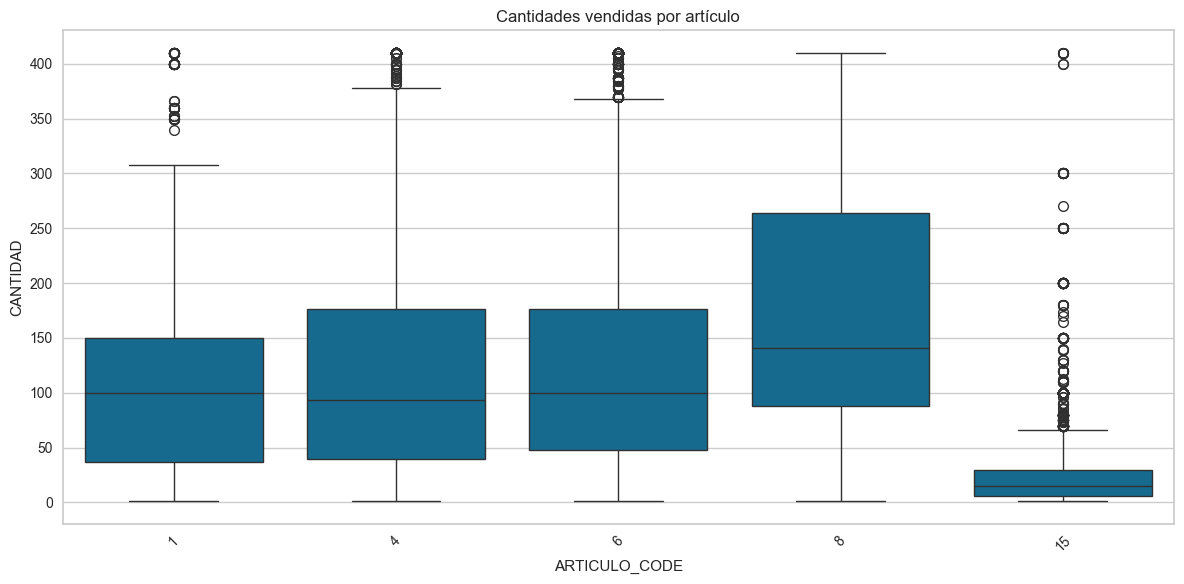

In [99]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='ARTICULO_CODE', y='CANTIDAD', data=df2model)
plt.title('Cantidades vendidas por artículo')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

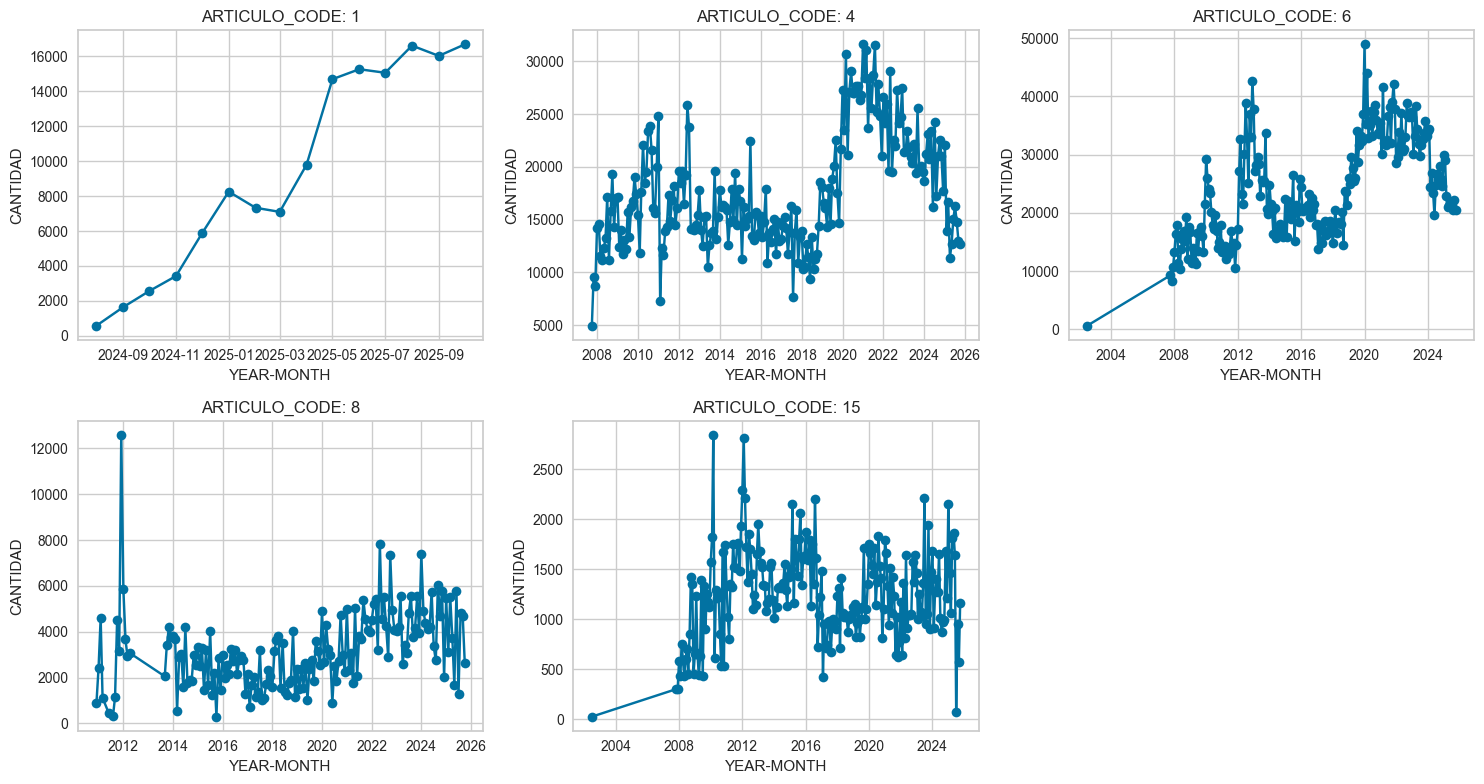

In [100]:
# Series de tiempo

# YEAR-MONTH
df2model['YEAR_MONTH'] = df2model['F_EMISION'].dt.to_period('M').dt.to_timestamp()
ARTICULO_CODEs = df2model['ARTICULO_CODE'].unique()
n3 = len(ARTICULO_CODEs)

# Layout
cols = 3
rows = -(-n3 // cols)  # Ceiling division

# Subplots
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# Plot for each ARTICULO_CODE
for i, ARTICULO_CODE in enumerate(ARTICULO_CODEs):
    subset = (
        df2model[df2model['ARTICULO_CODE'] == ARTICULO_CODE]
        .groupby('YEAR_MONTH')['CANTIDAD']
        .sum()
        .reset_index())

    axes[i].plot(subset['YEAR_MONTH'], subset['CANTIDAD'], marker='o')
    axes[i].set_title(f'ARTICULO_CODE: {ARTICULO_CODE}')
    axes[i].set_xlabel('YEAR-MONTH')
    axes[i].set_ylabel('CANTIDAD')
    axes[i].grid(True)


hide_axes(i, axes, fig)
plt.tight_layout()
plt.show()


In [101]:
df2model = df2model.drop(columns=['YEAR_MONTH'])

También se pueden utilizar métodos de filtrado para la selección de características y técnicas de reducción de dimensionalidad.

La dimensionalidad en este caso no representa un problema, por lo cual no se aplica ninguna técnica de reducción

**CONCLUSIONES:** Enumerar y justificar las decisiones y técnicas empleadas.

---

## **ETAPA IV:** Modelación y evaluación del modelo

En esta etapa se construyen y evalúan varios modelos usando diversos algoritmos. En caso de que los resultados sean deficientes, la metodología permite volver al primer paso para tener una comprensión de lo que está ocurriendo.


Las siguientes son acciones que se pueden abordar en este avance:
* Particionar los datos en conjunto de entrenamiento y conjunto de prueba (SI APLICA).
* Considerar al menos 3 modelos diferentes (con algoritmos variados) o 3 técnicas de modelado.
* Inspeccionar visualmente los resultados del clustering (SI APLICA).
* Sintetizar los resultados en una tabla comparativa ordenando los modelos por la métrica principal (definida en los criterios de éxito) e incorporando otras métricas pertinentes. Se deberán incluir también los tiempos de entrenamiento.
* Elegir el modelo final alineado con los objetivos y necesidades del negocio.
* Ajustar el modelo que proporcione el mejor rendimiento (OPCIONAL)

In [102]:
# Particionar los datos en conjunto de entrenamiento y conjunto de prueba

train, test = train_test_split(df2model, train_size=0.8, random_state=1) #,random_state=1
print('Train:', len(train), '\n Test:', len(test))


Train: 63768 
 Test: 15943


In [103]:
# Input / Output

y = 'CANTIDAD'
x = list(train.columns)
x.remove(y)

x

['CNT_PRODS_VENTA',
 'TIPO_DOC',
 'DIAS',
 'UNIDAD',
 'PRECIO',
 'F_EMISION',
 'YEAR',
 'MONTH',
 'TEMPORADA',
 'FESTIVIDAD',
 'MARCA_CASA',
 'ARTICULO_CODE']

In [ ]:
print(train[y].describe(), '\n\n', train[y].nunique())


count       63768.0
mean     125.276502
std      118.159899
min             1.0
25%            28.0
50%            88.0
75%           176.0
max           410.0
Name: CANTIDAD, dtype: Float64 

 348


In [108]:
from pycaret.regression import *
pyc = setup(data=train, target=y, test_data=test, preprocess=True, session_id=1, fold_strategy='timeseries', data_split_shuffle=False, fold_shuffle=False) 


,Description,Value
0,Session id,1
1,Target,CANTIDAD
2,Target type,Regression
3,Original data shape,"(79711, 13)"
4,Transformed data shape,"(79711, 18)"
5,Transformed train set shape,"(63768, 18)"
6,Transformed test set shape,"(15943, 18)"
7,Numeric features,10
8,Date features,1
9,Categorical features,1


In [109]:
leader = compare_models(sort='r2', budget_time=1.5, fold=5) #budget_time=1.5, fold=5, , sort='r2'
leader

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,63.2870,7535.5554,86.7847,0.4605,0.9339,1.7023,0.2680
lightgbm,Light Gradient Boosting Machine,64.3557,7658.1630,87.5076,0.4517,0.9450,1.7979,0.2500
rf,Random Forest Regressor,63.1624,8001.1199,89.4298,0.4272,0.9078,1.6289,1.7380
gbr,Gradient Boosting Regressor,69.3513,8628.5622,92.8889,0.3823,1.0183,2.1254,0.9660
knn,K Neighbors Regressor,68.9773,9274.4590,96.2649,0.3360,0.9660,1.7513,0.5500
et,Extra Trees Regressor,66.7441,9388.0127,96.8795,0.3279,0.9698,1.7055,1.4760
ada,AdaBoost Regressor,81.7420,10346.6831,101.7090,0.2594,1.1843,3.2997,0.2280
ridge,Ridge Regression,78.4402,10459.2500,102.2695,0.2513,1.1738,3.1236,0.5200
br,Bayesian Ridge,78.4367,10458.3335,102.2650,0.2513,1.1746,3.1255,0.0860
lr,Linear Regression,78.4412,10459.4960,102.2707,0.2512,1.1737,3.1233,0.8480


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cpu', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [110]:
evaluate_model(leader)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [48]:
# Considerar al menos 3 modelos diferentes (con algoritmos variados) o 3 técnicas de modelado

from tpot import TPOTRegressor

tpot = TPOTRegressor(generations=5, population_size=50, random_state=1, scoring='r2', verbosity=2)
tpot.fit(train[x], train[y])

ImportError: cannot import name 'get_tags' from 'sklearn.utils._tags' (d:\ARCHIVOS\Phyton\lib\site-packages\sklearn\utils\_tags.py)

In [ ]:
from pycaret.regression import *

#train.drop(columns='F_EMISION', inplace=True)

train['YEAR_MONTH'] = train['YEAR_MONTH'].astype(str)
train = train.sort_values(['ARTICULO_CODE', 'YEAR_MONTH'])

# Correct PyCaret setup
exp = setup(
    train=train,
    target='CANTIDAD',
    categorical_features=['ARTICULO_CODE'],
    numeric_features=['YEAR', 'MONTH'],
    fold_strategy='timeseries',
    fold=3,
    train_split_shuffle=False,
    fold_shuffle=False,
    session_id=123
)

# AutoML
best_model = compare_models()
final_model = finalize_model(best_model)
future_preds = predict_model(final_model)


In [ ]:
# !pip install tpot

from tpot import TPOTRegressor
from sklearn.model_selection import TimeSeriesSplit

# Prepare features and target
X = df2model[['ARTICULO_CODE', 'YEAR', 'MONTH', 'CANTIDAD']]
y = df2model['VENTA']

# Time-series aware split
tscv = TimeSeriesSplit(n_splits=3)

tpot = TPOTRegressor(
    generations=5, 
    population_size=20, 
    verbosity=2, 
    cv=tscv,
    random_state=42
)

tpot.fit(X, y)

# Evaluate
print(tpot.score(X, y))

# Export the optimized pipeline
tpot.export('best_pipeline.py')


In [ ]:
# Sintetizar los resultados en una tabla comparativa ordenando los modelos por la métrica principal 

**CONCLUSIONES**: ¿El rendimiento del modelo es lo suficientemente bueno para su implementación en producción? ¿Existe margen para mejorarlo? ¿Cuáles serían las recomendaciones clave para poder implementar la solución?

---